In [1]:
import os
import glob
import operator as op

import numpy             as np
import matplotlib.pyplot as plt

from CCfun  import in_range
from CCfun  import compute_baseline_float
from CCfun  import datetime_from_spectrum

from CCplot import plot1d
from CCplot import plot_line
from CCplot import auto_plot_style
from CCplot import figure_sizes
from CCplot import subplots

from CCfit  import gauss_poly
from CCfit  import expo
from CCfit  import fit

from CCio import load_ccd_file

In [2]:
firstday  = "/home/gonzalo/data/CC//Consistency_sapphire_2021_01_28_15_43_01_390400/"
secondday = "/home/gonzalo/data/CC//Consistency_sapphire_2021_02_07_13_25_51_438000/"

auto_plot_style({"font.size": 25, "lines.markersize" : 10})

In [3]:
def lmap(*args):
    return list(map(*args))

def npmap(*args):
    return np.array(lmap(*args))

def orderer(filename):
    basename = filename.split("/")[-1]
    tokens   = basename.split("_")
    index    = 0
    for token in tokens:
        if token[0].isdigit():
            index = 100 * index + int(token)
    return index

def find_max(x, y):
    m  = in_range(x, 600, 1000)
    return y[m].max()

def integrate(emwl, spectrum, rebin_by=1, plot=False):
    x  = emwl
    y  = spectrum
    y -= compute_baseline_float(y)
    if rebin_by > 1:
        x = rebin(x, rebin_by, np.mean)
        y = rebin(y, rebin_by, np.sum )
    
    s  = find_max(x, y), 770,  30,  0
    f  = fit(gauss_poly, x, y, s, fit_range = (600, 1000), maxfev=int(1e6))
    if plot:
        plt.plot(x, y, "k.")
        plt.plot(x, f.fn(x), "b-")
    return f.values[0] * np.diff(x)[0]

def integrate2(emwl, spectrum):
    sel = in_range(emwl, 600, 1000)
    return np.sum(spectrum[sel]) * np.diff(emwl)[0]

# Same position, nothing moved, repeated measurements

In [4]:
filenames = sorted(glob.glob(os.path.join(firstday, "Constant", "*signal*")), key=orderer)
datas     =  lmap(load_ccd_file, filenames)
em_wls    =  lmap(op.attrgetter("em_wl"), datas)
times     = npmap(datetime_from_spectrum, datas)
times     = npmap(op.attrgetter("seconds"), times - times[0]) * 1.0
spectra   = [s.rate / s.power[0].mean for s in datas]
peaks     = npmap(find_max, em_wls, spectra)
integrals = npmap(integrate2, em_wls, spectra)

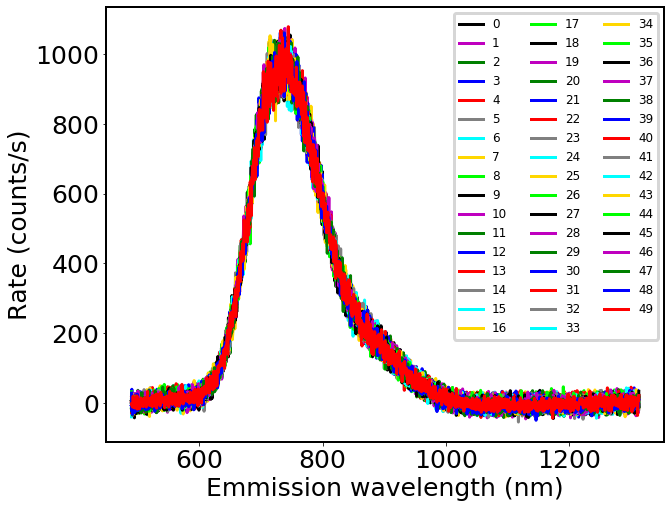

In [5]:
for k, data in enumerate(datas):
    plt.plot(data.em_wl, data.rate, label=str(k))
    
plt.xlabel("Emmission wavelength (nm)")
plt.ylabel("Rate (counts/s)")
plt.legend(ncol=3, fontsize=12)

Text(0, 0.5, 'Rate (counts/s)')

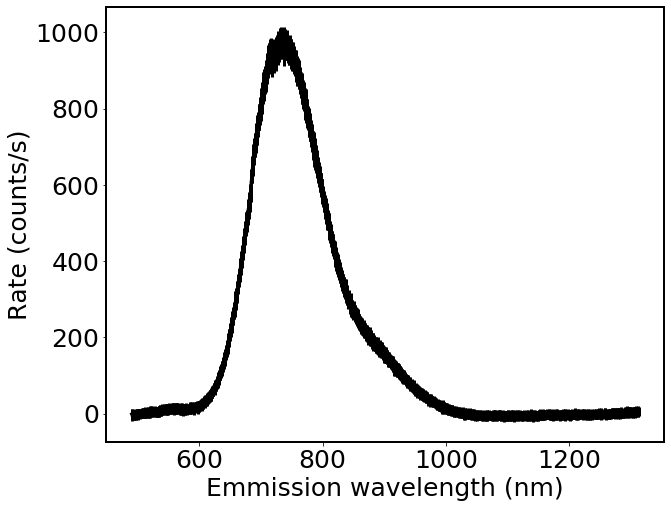

In [6]:
acc = np.asarray([data.rate for data in datas])
ave = acc.mean(axis=0)
rms = acc.std (axis=0)
plt.errorbar(datas[0].em_wl, ave, rms)

plt.xlabel("Emmission wavelength (nm)")
plt.ylabel("Rate (counts/s)")

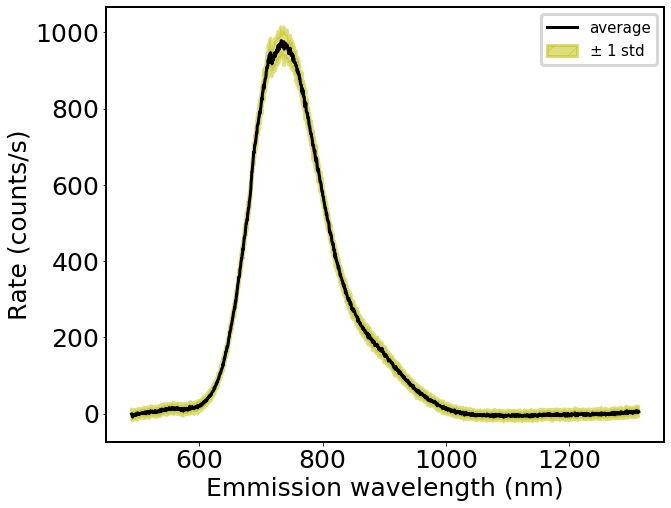

In [7]:
plt.plot(datas[0].em_wl, ave, label="average")
plt.fill_between(datas[0].em_wl, ave - rms, ave + rms, color="y", hatch="/", alpha=0.5, label="$\pm$ 1 std")

plt.xlabel("Emmission wavelength (nm)")
plt.ylabel("Rate (counts/s)")
plt.legend(fontsize=15)

[ 8.62900190e+03 -5.62095522e-02  1.01339390e+00 -2.39986596e+00]
[1.91896357e+01 2.11924169e-03 2.29159472e-03 2.06665925e+00]


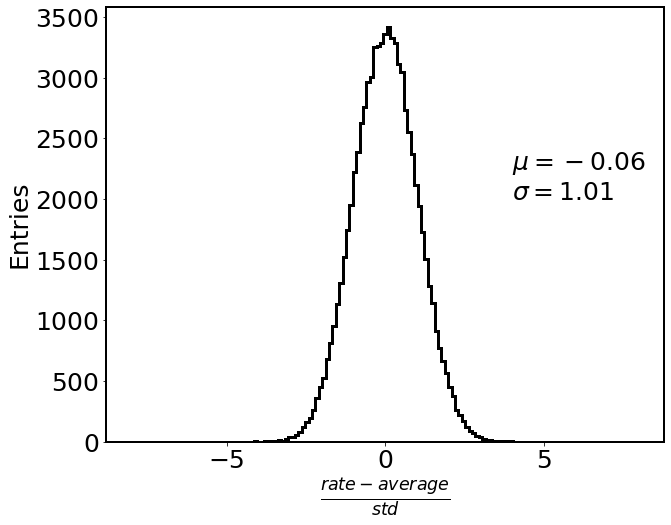

In [8]:
emwl = np.asarray([data.em_wl for data in datas]).flatten()
pull = np.asarray([(data.rate - ave) / rms for data in datas]).flatten()

y, x, _ = plt.hist(pull, np.linspace(-8, 8, 150), histtype="step")
plt.xlabel("$\\frac{rate - average}{std}$")
plt.ylabel("Entries")

f = fit(gauss_poly, x[:-1], y, (1, 0, 1, 0))

plt.text(4, 2000, f"$\mu = {f.values[1]:.2f}$\n$\sigma = {f.values[2]:.2f}$")
print(f.values)
print(f.errors)

Text(0, 0.5, 'Integral')

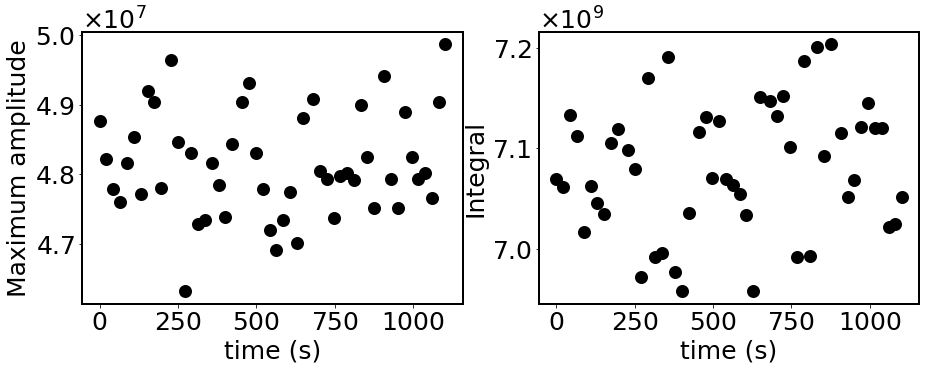

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(times, peaks)
plt.xlabel("time (s)")
plt.ylabel("Maximum amplitude")


plt.subplot(1, 2, 2)
plt.scatter(times, integrals)
plt.xlabel("time (s)")
plt.ylabel("Integral")

# Same position, take out and put back

In [10]:
filenames = sorted(glob.glob(os.path.join(firstday, "Takeout", "*signal*")), key=orderer)
datas     =  lmap(load_ccd_file, filenames)
em_wls    =  lmap(op.attrgetter("em_wl"), datas)
times     = npmap(datetime_from_spectrum, datas)
times     = npmap(op.attrgetter("seconds"), times - times[0]) * 1.0
spectra   = [s.rate / s.power[0].mean for s in datas]
peaks     = npmap(find_max, em_wls, spectra)
integrals = npmap(integrate2, em_wls, spectra)

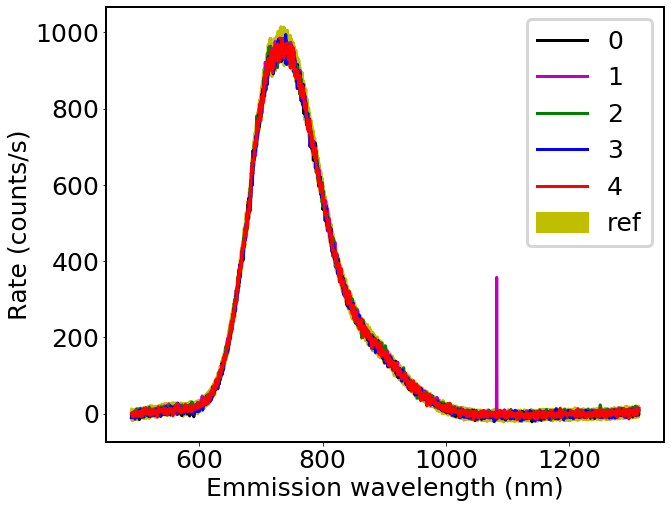

In [11]:
plt.fill_between(datas[0].em_wl, ave - rms, ave + rms, color="y", hatch="/", label="ref")
for ig in range(5):
    ds = datas[ig*5: ig*5 + 5]
    acc = np.asarray([data.rate for data in ds])
    ave = acc.mean(axis=0)
    plt.plot(ds[0].em_wl, ave, label=str(ig))

plt.xlabel("Emmission wavelength (nm)")
plt.ylabel("Rate (counts/s)")
plt.legend()

Text(0, 0.5, 'Integral')

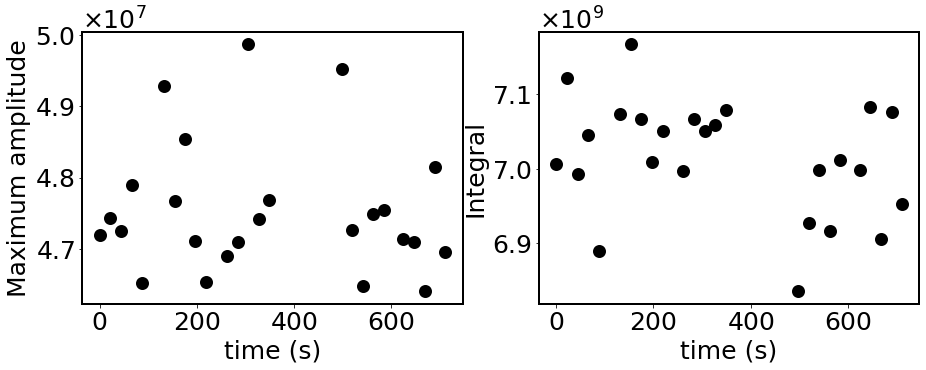

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(times, peaks)
plt.xlabel("time (s)")
plt.ylabel("Maximum amplitude")


plt.subplot(1, 2, 2)
plt.scatter(times, integrals)
plt.xlabel("time (s)")
plt.ylabel("Integral")

# After a few days

In [13]:
filenames2 = sorted(glob.glob(os.path.join(secondday, "Constant", "*signal*")), key=orderer)
datas2     =  lmap(load_ccd_file, filenames2)
em_wls2    =  lmap(op.attrgetter("em_wl"), datas2)
times2     = npmap(datetime_from_spectrum, datas2)
times2     = npmap(op.attrgetter("seconds"), times2 - times2[0]) * 1.0
spectra2   = [s.rate / s.power[0].mean for s in datas2]
peaks2     = npmap(find_max, em_wls2, spectra2)
integrals2 = npmap(integrate2, em_wls2, spectra2)

/home/gonzalo/sw/git/CC/CCio.py:127: UserWarning: loadtxt: Empty input file: "/home/gonzalo/data/CC//Consistency_sapphire_2021_02_07_13_25_51_438000/Constant/measurement_0_power_crystal.asc"
  times, powers = np.loadtxt(filename, delimiter=",").T
/home/gonzalo/sw/git/CC/CCio.py:127: UserWarning: loadtxt: Empty input file: "/home/gonzalo/data/CC//Consistency_sapphire_2021_02_07_13_25_51_438000/Constant/measurement_1_power_crystal.asc"
  times, powers = np.loadtxt(filename, delimiter=",").T
/home/gonzalo/sw/git/CC/CCio.py:127: UserWarning: loadtxt: Empty input file: "/home/gonzalo/data/CC//Consistency_sapphire_2021_02_07_13_25_51_438000/Constant/measurement_2_power_crystal.asc"
  times, powers = np.loadtxt(filename, delimiter=",").T
/home/gonzalo/sw/git/CC/CCio.py:127: UserWarning: loadtxt: Empty input file: "/home/gonzalo/data/CC//Consistency_sapphire_2021_02_07_13_25_51_438000/Constant/measurement_3_power_crystal.asc"
  times, powers = np.loadtxt(filename, delimiter=",").T
/home/gonzal

/home/gonzalo/sw/git/CC/CCio.py:127: UserWarning: loadtxt: Empty input file: "/home/gonzalo/data/CC//Consistency_sapphire_2021_02_07_13_25_51_438000/Constant/measurement_42_power_crystal.asc"
  times, powers = np.loadtxt(filename, delimiter=",").T
/home/gonzalo/sw/git/CC/CCio.py:127: UserWarning: loadtxt: Empty input file: "/home/gonzalo/data/CC//Consistency_sapphire_2021_02_07_13_25_51_438000/Constant/measurement_43_power_crystal.asc"
  times, powers = np.loadtxt(filename, delimiter=",").T
/home/gonzalo/sw/git/CC/CCio.py:127: UserWarning: loadtxt: Empty input file: "/home/gonzalo/data/CC//Consistency_sapphire_2021_02_07_13_25_51_438000/Constant/measurement_44_power_crystal.asc"
  times, powers = np.loadtxt(filename, delimiter=",").T
/home/gonzalo/sw/git/CC/CCio.py:127: UserWarning: loadtxt: Empty input file: "/home/gonzalo/data/CC//Consistency_sapphire_2021_02_07_13_25_51_438000/Constant/measurement_45_power_crystal.asc"
  times, powers = np.loadtxt(filename, delimiter=",").T
/home/go

Text(0, 0.5, 'Rate (counts/s)')

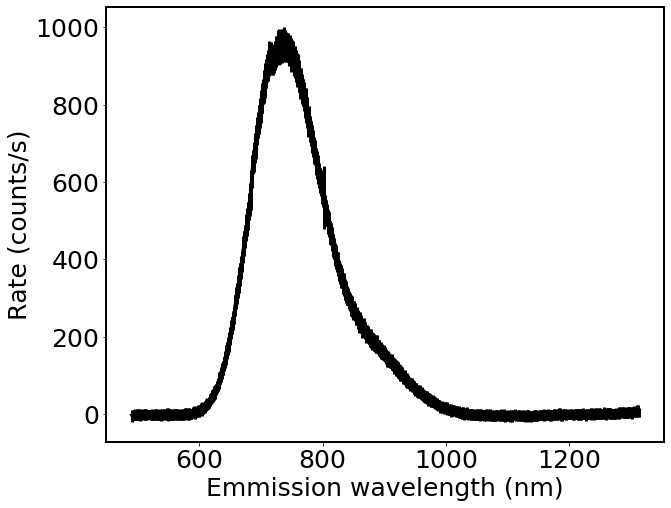

In [14]:
acc2 = np.asarray([data.rate for data in datas2])
ave2 = acc2.mean(axis=0)
rms2 = acc2.std (axis=0)
plt.errorbar(datas2[0].em_wl, ave2, rms2)

plt.xlabel("Emmission wavelength (nm)")
plt.ylabel("Rate (counts/s)")

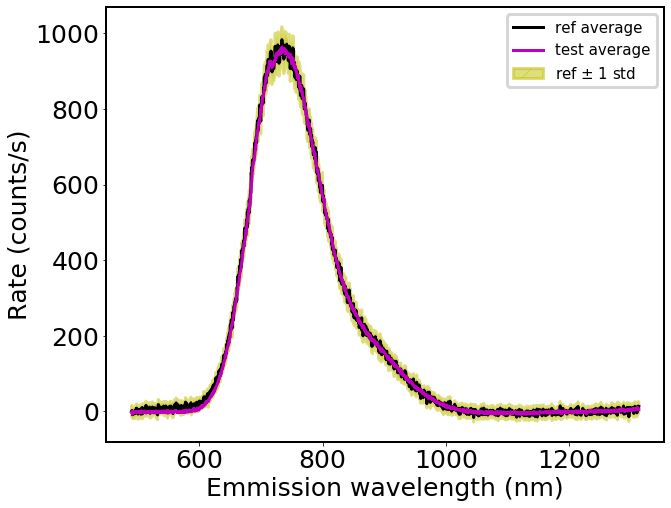

In [19]:
plt.plot(datas [0].em_wl, ave , label="ref average")
plt.plot(datas2[0].em_wl, ave2, label="test average")
plt.fill_between(datas[0].em_wl, ave - rms, ave + rms, color="y", hatch="/", alpha=0.5, label="ref $\pm$ 1 std")

plt.xlabel("Emmission wavelength (nm)")
plt.ylabel("Rate (counts/s)")
plt.legend(fontsize=15)